# -----------------------------------Real Time Face Detection----------------------------------------

## Import Dependencies

In [1]:
import os
import time
import uuid
import cv2

In [2]:
#Path Of Directory in which images will be saved
IMAGES_PATH = os.path.join('data','images')
number_images = 10

In [4]:
valid_cams = []
for i in range(5):
    cap = cv2.VideoCapture(i)
    if cap is None or not cap.isOpened():
        print('Warning: unable to open video source: ', i)
    else:
        valid_cams.append(i)
print('valid camera',valid_cams)

valid camera [0]


## Capturing Images

In [5]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(1.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [4]:
#Library which is used to labels the images
!labelme

[INFO   ] __init__:get_config:70 - Loading config file from: C:\Users\Lenovo\.labelmerc


## Data Preprocessing

In [2]:
#more libraries for data preprocessing
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [4]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [31]:
images.as_numpy_iterator().next()

b'data\\images\\c4869916-3c02-11ee-a0b7-0045e279cb70.jpg'

In [5]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [5]:
images = images.map(load_image)

In [34]:
images.as_numpy_iterator().next()

array([[[199, 222, 214],
        [198, 221, 213],
        [197, 220, 210],
        ...,
        [171, 176, 195],
        [172, 173, 194],
        [174, 174, 198]],

       [[199, 222, 216],
        [198, 221, 213],
        [198, 221, 213],
        ...,
        [170, 177, 195],
        [170, 172, 195],
        [170, 172, 195]],

       [[198, 220, 217],
        [197, 220, 214],
        [197, 220, 214],
        ...,
        [175, 186, 204],
        [177, 183, 205],
        [177, 183, 207]],

       ...,

       [[187, 198, 194],
        [187, 198, 194],
        [187, 198, 194],
        ...,
        [174, 180, 196],
        [176, 182, 198],
        [178, 184, 200]],

       [[187, 197, 196],
        [187, 197, 196],
        [187, 197, 196],
        ...,
        [175, 182, 200],
        [176, 183, 201],
        [179, 186, 204]],

       [[185, 195, 194],
        [184, 194, 193],
        [184, 194, 193],
        ...,
        [177, 184, 202],
        [178, 185, 203],
        [180, 187, 205]]

In [35]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

## View Raw Images with Matplotlib

In [36]:
image_generator = images.batch(4).as_numpy_iterator()

In [37]:
plot_images = image_generator.next()

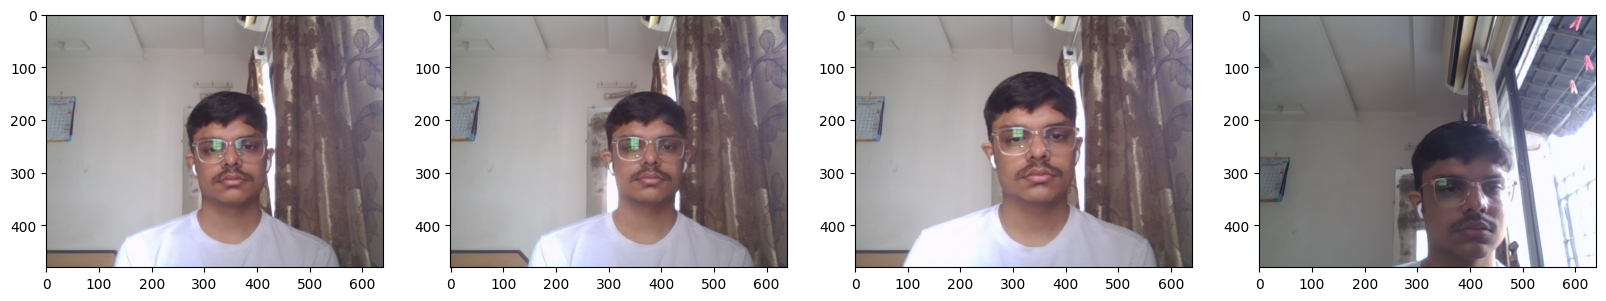

In [38]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

In [17]:
#Split images into train-test-val
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

## Apply Image Augmentation on Images and Labels using Albumentations

In [7]:
import albumentations as alb

In [19]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [20]:
img = cv2.imread(os.path.join('data','train', 'images','d4c1a445-3c02-11ee-b1aa-0045e279cb70.jpg'))

In [21]:
with open(os.path.join('data', 'train', 'labels', 'd4c1a445-3c02-11ee-b1aa-0045e279cb70.json'), 'r') as f:
    label = json.load(f)

In [22]:
label['shapes'][0]['points']

[[264.41340782122904, 176.31284916201116],
 [418.04469273743007, 376.3128491620112]]

In [23]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [24]:
coords

[264.41340782122904, 176.31284916201116, 418.04469273743007, 376.3128491620112]

In [25]:
coords = list(np.divide(coords, [640,480,640,480]))

In [26]:
coords

[0.41314594972067037,
 0.36731843575418993,
 0.6531948324022345,
 0.7839851024208567]

In [27]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [39]:
augmented['bboxes']

[(0.3920297951582868,
  0.1637492240844195,
  0.7334326505276224,
  0.608193668528864)]

In [41]:
augmented['bboxes'][0][2:]

(0.7334326505276224, 0.608193668528864)

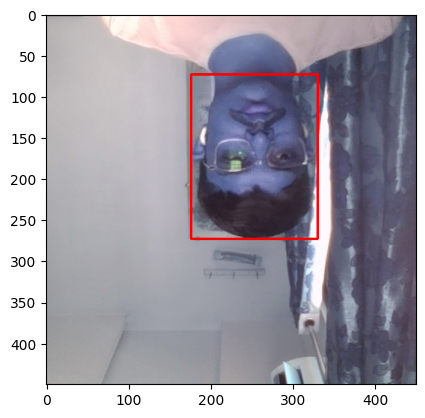

In [42]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

In [43]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

image must be numpy array type
x_max is less than or equal to x_min for bbox [0.2603875698324022, 0.2963221601489758, 0.0, 0.898468415386406, 'face'].
x_max is less than or equal to x_min for bbox [0.14952863128491617, 0.6722532588454376, 0.0011347765363128204, 0.0018621973929236763, 'face'].
x_max is less than or equal to x_min for bbox [0.43758729050279327, 0.9527467411545625, 0.0054993016759776305, 0.011173184357541924, 'face'].
x_max is less than or equal to x_min for bbox [0.3703736033519553, 0.7711824953445066, 0.0, 0.0026137973089937817, 'face'].


## Load Augmented Images to Tensorflow Dataset

In [6]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [7]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [8]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [9]:
train_images.as_numpy_iterator().next()

array([[[0.79509807, 0.7378064 , 0.7318627 ],
        [0.8000613 , 0.7406863 , 0.7291054 ],
        [0.7941176 , 0.7235294 , 0.71568626],
        ...,
        [0.9004902 , 0.94754905, 0.9397059 ],
        [0.89344364, 0.94050246, 0.9401348 ],
        [0.89209557, 0.93719363, 0.9338235 ]],

       [[0.8117647 , 0.749326  , 0.7444853 ],
        [0.8088848 , 0.7382353 , 0.7302696 ],
        [0.8161765 , 0.7416667 , 0.7259804 ],
        ...,
        [0.8980392 , 0.94411767, 0.9367647 ],
        [0.89460784, 0.94166666, 0.9338235 ],
        [0.8898897 , 0.9490196 , 0.9372549 ]],

       [[0.8156863 , 0.74509805, 0.7372549 ],
        [0.827451  , 0.7529412 , 0.7372549 ],
        [0.8338235 , 0.75147057, 0.73970586],
        ...,
        [0.8985907 , 0.93780637, 0.9338848 ],
        [0.89074755, 0.93780637, 0.92996323],
        [0.89215684, 0.9474265 , 0.93400735]],

       ...,

       [[0.579473  , 0.606924  , 0.67965686],
        [0.7056373 , 0.7270833 , 0.800674  ],
        [0.5831495 , 0

## Prepare Labels

In [10]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [11]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [12]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [13]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [14]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.    , 0.2305, 0.281 , 0.644 ], dtype=float16))

## Combine Label and Image Samples

In [15]:
#Check Partition Lengths
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(2340, 2340, 540, 540, 540, 540)

In [16]:
#Create Final Datasets (Images/Labels)
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(3000)
train = train.batch(8)
train = train.prefetch(4)

In [17]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1000)
test = test.batch(8)
test = test.prefetch(4)

In [18]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [19]:
train.as_numpy_iterator().next()[0].shape

(8, 120, 120, 3)

In [20]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0],
        [1]], dtype=uint8),
 array([[0.4895, 0.2805, 0.9043, 0.8193],
        [0.3257, 0.0396, 0.774 , 0.5947],
        [0.1665, 0.4094, 0.626 , 0.9766],
        [0.    , 0.    , 0.    , 0.    ],
        [0.1775, 0.2886, 0.565 , 0.7676],
        [0.1553, 0.2668, 0.5513, 0.7773],
        [0.    , 0.    , 0.    , 0.    ],
        [0.1692, 0.2092, 0.6147, 0.7603]], dtype=float16))

## View Images and Annotations

In [6]:
data_samples = train.as_numpy_iterator()
res = data_samples.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

In [47]:
##############
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [48]:
# vgg architecture  of cnn
vgg = VGG16(include_top=False)

In [49]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

## Defining Neural Network

In [50]:
##################
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [51]:
facetracker = build_model()

In [52]:
facetracker.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_5[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d_2 (Global  (None, 512)         0           ['vgg16[0][0]']                  
 MaxPooling2D)                                                                              

In [53]:
X, y = train.as_numpy_iterator().next()

In [54]:
X.shape

(8, 120, 120, 3)

In [55]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 0s 455ms/step


In [56]:
#classes are predict whether face is available or not in frame
#coords are creating boundry box over the face 
classes, coords

(array([[0.52816355],
        [0.5708337 ],
        [0.54597443],
        [0.55949026],
        [0.4890396 ],
        [0.58289284],
        [0.49213412],
        [0.44573137]], dtype=float32),
 array([[0.42240763, 0.47608298, 0.36558446, 0.52399904],
        [0.45767596, 0.54532605, 0.42602536, 0.47437084],
        [0.4489747 , 0.56880707, 0.30377203, 0.46397677],
        [0.4072262 , 0.5051013 , 0.3441093 , 0.4788572 ],
        [0.39522058, 0.46158335, 0.27129713, 0.5053415 ],
        [0.42671886, 0.60376227, 0.3026155 , 0.4253834 ],
        [0.45851278, 0.53202134, 0.3180007 , 0.51977444],
        [0.4019278 , 0.50105923, 0.32050735, 0.5103315 ]], dtype=float32))

## Define Losses and Optimizers

In [57]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [58]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

In [59]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [60]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [61]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.4871845>

In [62]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.65872467>

In [63]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.4871845>

## Train Neural Network

In [64]:
############
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [65]:
#############
model = FaceTracker(facetracker)

In [66]:
model.compile(opt, classloss, regressloss)

In [67]:
logdir='logs'

In [68]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [7]:
hist = model.fit(train, epochs=5, validation_data=val, callbacks=[tensorboard_callback])

In [ ]:
hist.history

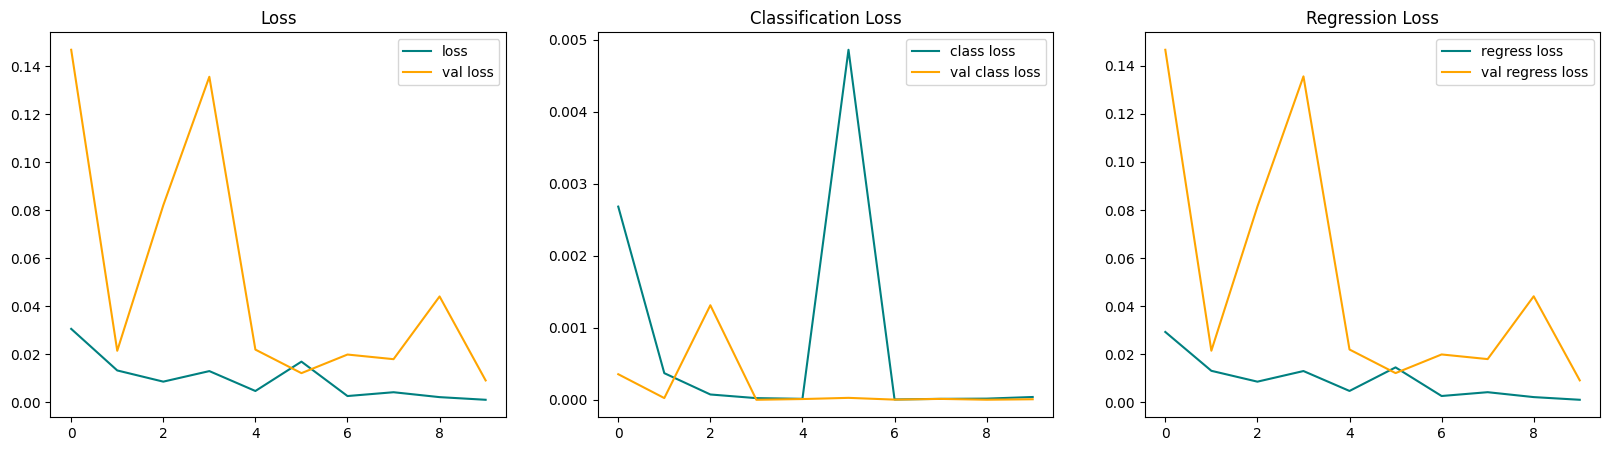

In [48]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

## Make Predictions

In [75]:
test_data = test.as_numpy_iterator()

In [76]:
test_sample = test_data.next()

In [77]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 236ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


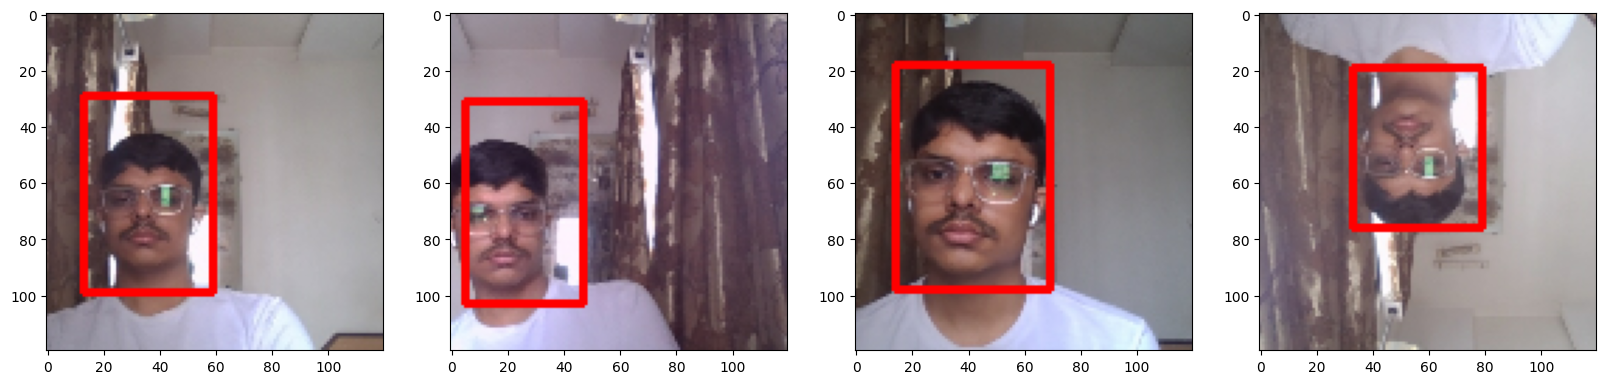

In [78]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

# Save the Model

In [79]:
from tensorflow.keras.models import load_model

In [80]:
facetracker.save('facetracker.h5')

In [81]:
facetracker = load_model('facetracker.h5')

# Real Time Detection

In [82]:
import numpy as np
import tensorflow as tf
import cv2

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 65ms/step
